Mushroom Classification using Unsupervised Learning.

Source: https://www.kaggle.com/minc33/k-means-clustering-vs-logistic-regression

We need to create an unsupervised learning algorithm that will learn how to classify mushrooms between poisonous and edible:

poisonous:  1
edible:     0


Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Read data

In [3]:
orig = pd.read_csv('mushrooms.csv')
#print(orig.head())

Divide our data into 'predictors,' X and 'labels,' y:

In [4]:
#The 'class' column contains our labels.
#It tells us whether the mushroom is 'poisonous' or 'edible'.
X = orig.drop(['class'], axis=1)
y = orig['class']

EDA: Exploration Data Analysis

In [9]:
for attr in X.columns:
    print("\n*", attr, "*")
    print(X[attr].value_counts())


* cap-shape *
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64

* cap-surface *
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64

* cap-color *
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64

* bruises *
f    4748
t    3376
Name: bruises, dtype: int64

* odor *
n    3528
f    2160
y     576
s     576
l     400
a     400
p     256
c     192
m      36
Name: odor, dtype: int64

* gill-attachment *
f    7914
a     210
Name: gill-attachment, dtype: int64

* gill-spacing *
c    6812
w    1312
Name: gill-spacing, dtype: int64

* gill-size *
b    5612
n    2512
Name: gill-size, dtype: int64

* gill-color *
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, dtype: int64

* stalk-shape *
t    4608
e    3516
Name: stalk-shape, dtype: int64

* stalk-root *
b    3776


All the values in the column: veil-type has the same value "p". So, that column does not tell us anything useful.

In [17]:
X.drop(['veil-type'], axis=1, inplace=True)

In [7]:
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


Second, the stalk-root variable has a '?' value for it's missing values. Rather than impute this missing value, I will divide the dataset into two sections: (1) where X['stalk-root']==? and (2) where X['stalk-root']!=?. Then, I will analyze the distribution of each variable within those two data sets to determine if they are similar.

I'm no mushroom expert, so I would expect that if the distributions vary greatly for each variable, then the fact that the stalk-root's are missing for some of the mushrooms -- and not missing for the others --may turn out to be useful/relevant information.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


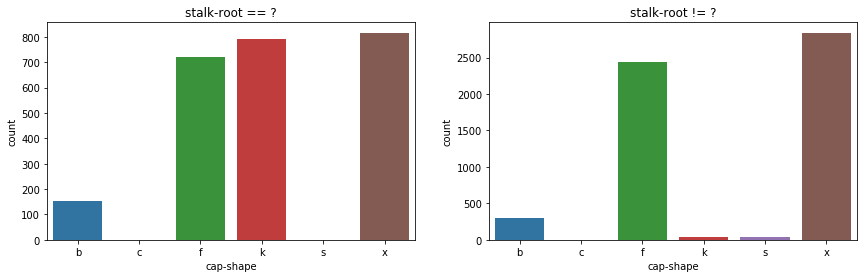

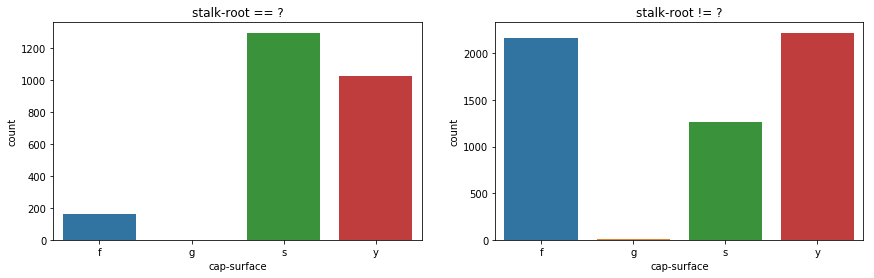

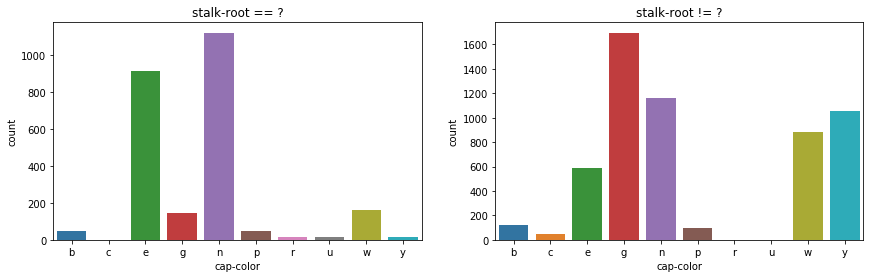

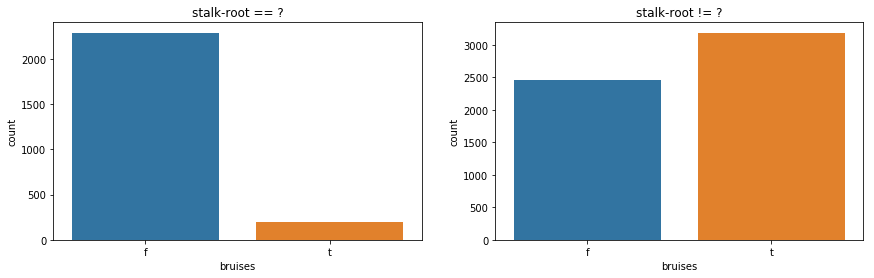

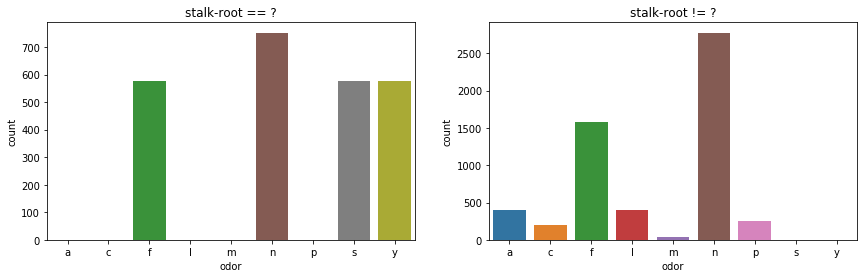

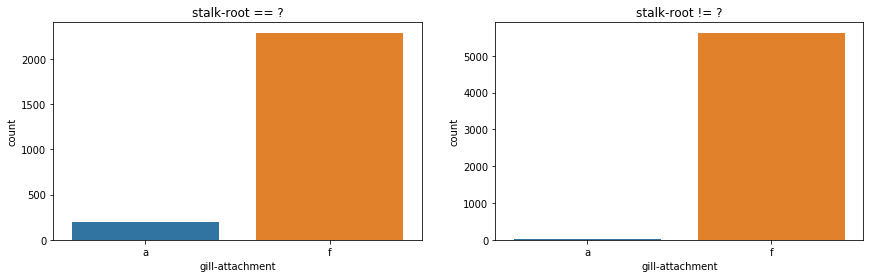

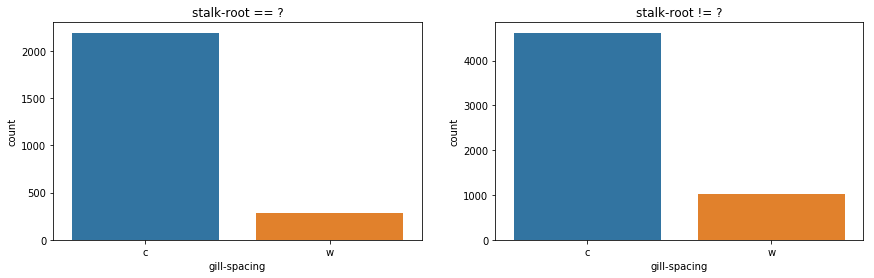

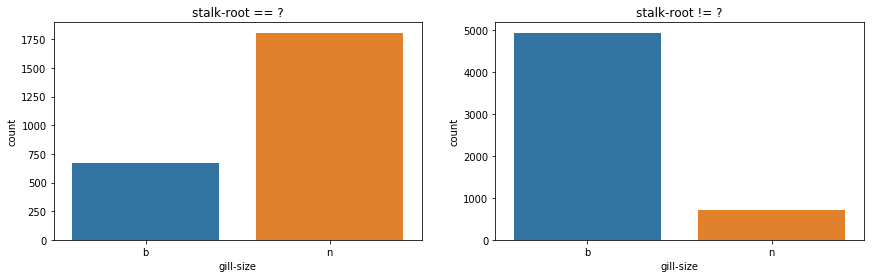

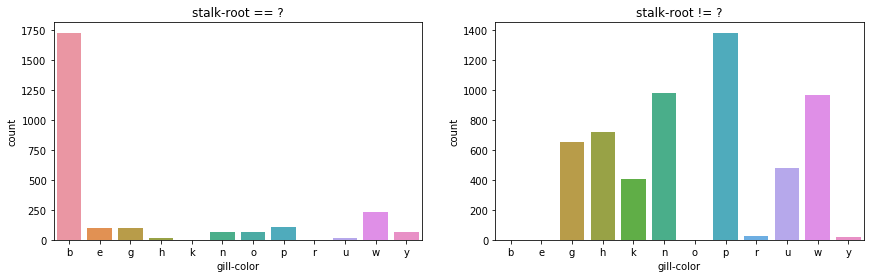

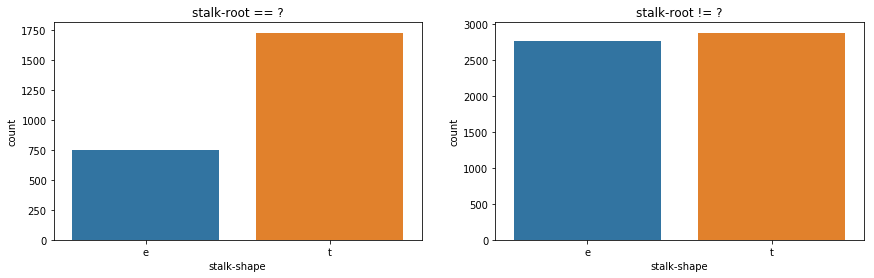

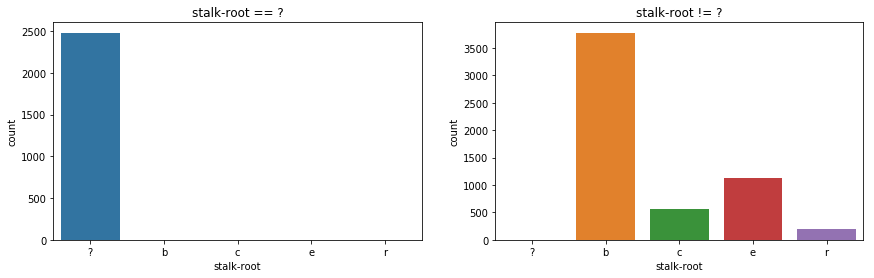

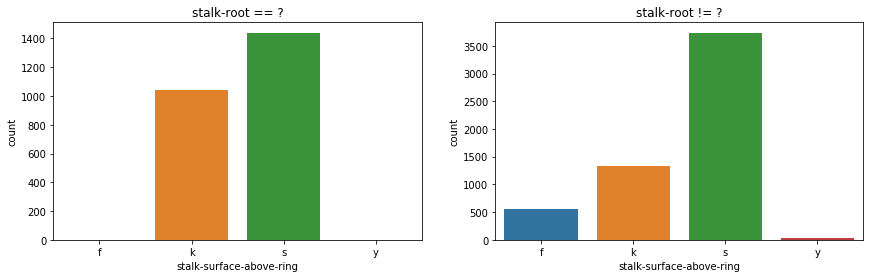

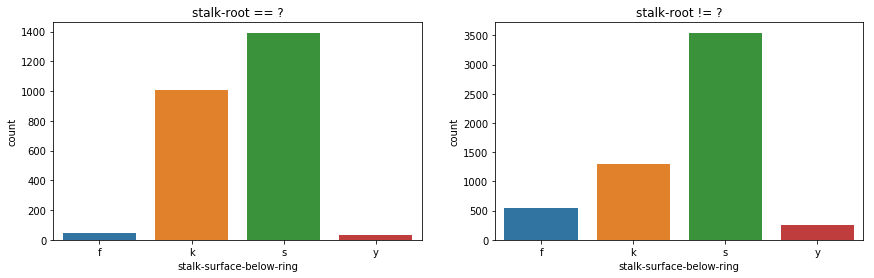

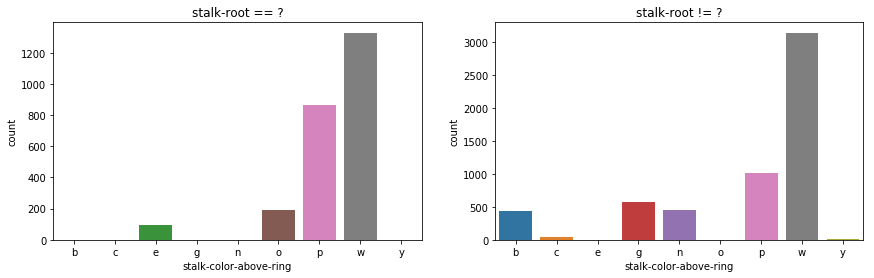

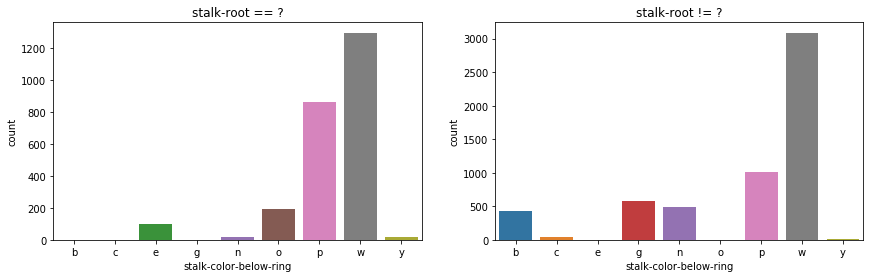

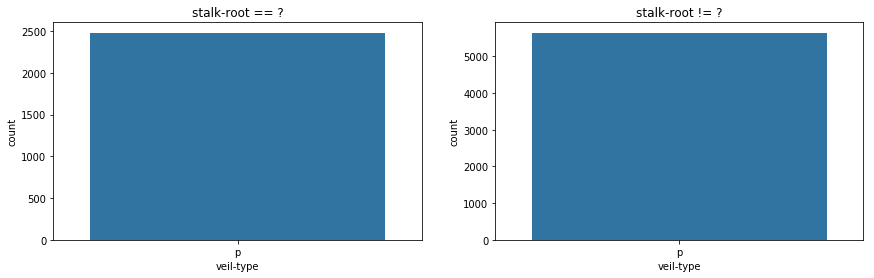

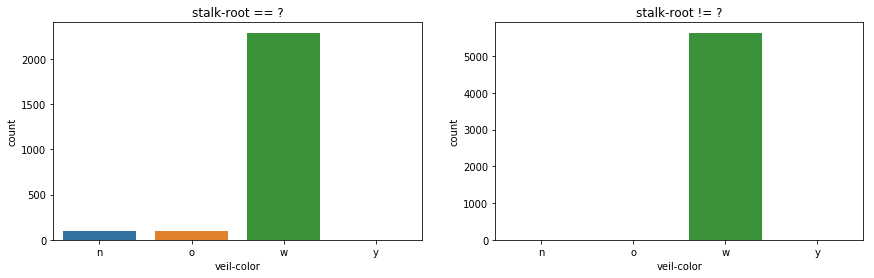

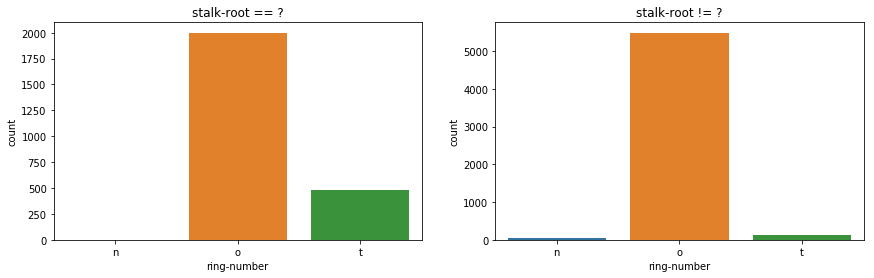

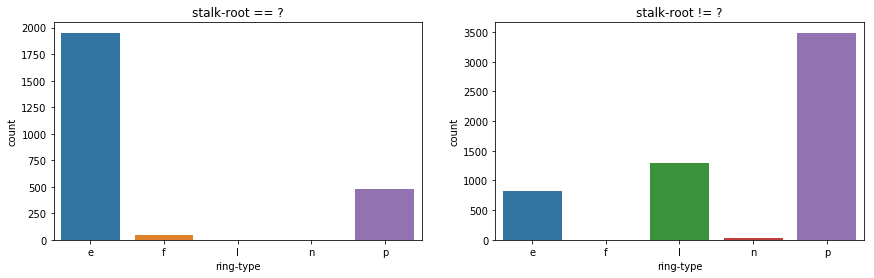

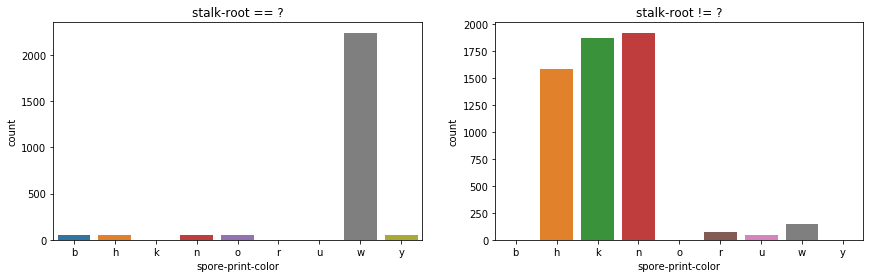

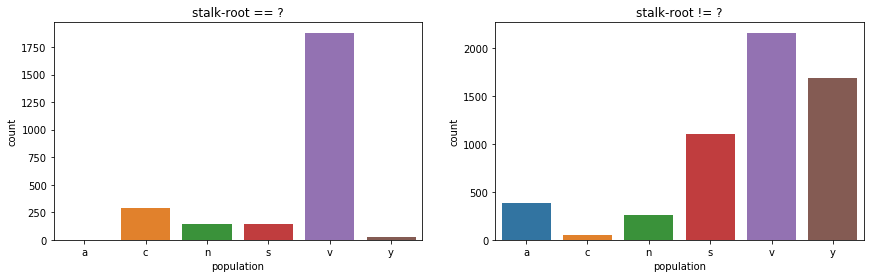

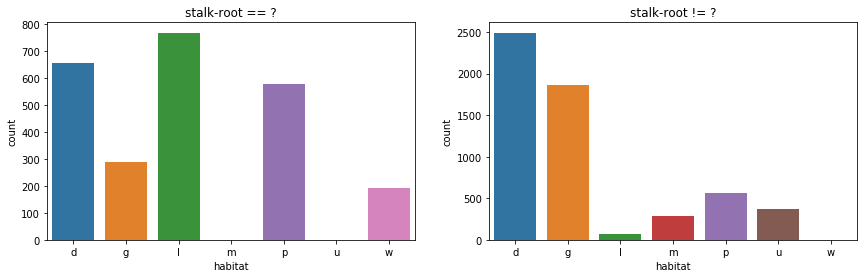

In [11]:
for attr in X.columns:
    #Format subplots
    fig, ax = plt.subplots(1,2)
    plt.subplots_adjust(right=2)
    
    #Construct values to count in each column
    a=set(X[X['stalk-root']=='?'][attr])
    b=set(X[X['stalk-root']!='?'][attr])
    c = a.union(b)
    c = np.sort(np.array(list(c)))
    
    #Build each subplot
    sns.countplot(x=X[X['stalk-root']=='?'][attr], order=c, ax=ax[0]).set_title('stalk-root == ?')
    sns.countplot(x=X[X['stalk-root']!='?'][attr], order=c, ax=ax[1]).set_title('stalk-root != ?')
    
    #Plot the plots
    fig.show()

We'll use a simple binary encoding for variables that hold only 2 possible values, and a one-hot-encoding for variables that hold 3 or more possible values.

In [12]:
#For columns with only two values
for col in X.columns:
    if len(X[col].value_counts()) == 2:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

In [13]:
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,1,p,1,0,1,k,0,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,1,a,1,0,0,k,0,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,1,l,1,0,0,n,0,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,1,p,1,0,1,n,0,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,0,n,1,1,0,k,1,...,s,w,w,p,w,o,e,n,a,g


To the rest of the variables use: one-hot-encode

In [14]:
X = pd.get_dummies(X)

In [15]:
X.head()

,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Cluster Analysis

In [16]:
#Initialize the model
kmeans = KMeans(n_clusters=2)

In [17]:
#Fit our model on the X dataset
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
#Calculate which mushrooms fall into which clusters
clusters = kmeans.predict(X)

In [19]:
#'cluster_df' will be used as a DataFrame
#to assist in the visualization
cluster_df = pd.DataFrame()

cluster_df['cluster'] = clusters
cluster_df['class'] = y

Now let's visualize the distribution of poisonous vs. edible mushrooms in each cluster.

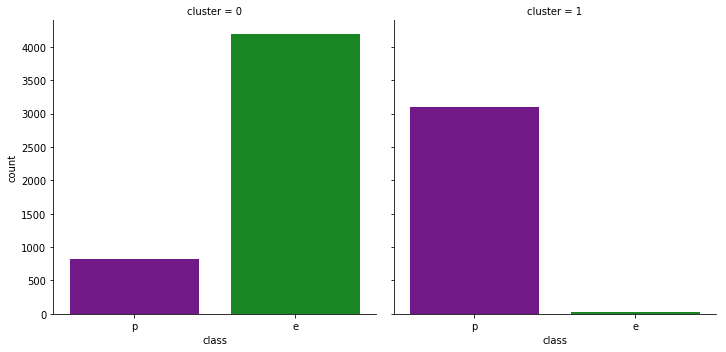

In [21]:
sns.factorplot(col='cluster', 
               y=None, 
               x='class', 
               data=cluster_df, 
               kind='count', 
               order=['p','e'], 
               palette=(["#7d069b","#069b15"]))

### Classification

But first, we need to encode our y-labels numerically so that our model can work with it.

Since each mushroom is either poisonous or edible, we will use another simple binary encoding like before:
    
Encoding our label "y" using another encoding.

In [22]:
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[1 0 0 ... 0 1 0]


So, when y==1, the mushroom is poisonous, and when y==0, the mushroom is edible.

Generate training and test from data:

In [23]:
#Our training set will hold 80% of the data
#and the test set will hold 20% of the data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20)

Initialize the models:

In [24]:
#K-Means Clustering with two clusters
kmeans = KMeans(n_clusters=2)

#Logistic Regression with no special parameters
logreg = LogisticRegression()

Fit our models:

In [29]:
kmeans.fit(train_X)  #Note that kmeans is unlabeled...

logreg.fit(train_X, train_y)#... while logreg IS labeled

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Make our predition using the test set:

In [30]:
kmeans_pred = kmeans.predict(test_X)

logreg_pred = logreg.predict(test_X)

One interesting aspect of K-Means clustering is that it does not always give the same results.

For example, if we were to run kmeans.fit(train_X) multiple times: part of the times, the majority of the poisonous mushrooms will fall into cluster 0, and the majority of the edible mushrooms will fall into cluster 1 - and on the other times: vice versa!

In order to get around this problem, we will build a second set of predictions from our K-Means model - kmeans_pred_2. This second set of predictions will simply be the bit-wise complement of kmeans_pred, and we will use whichever set of predictions gives us a better score as our final prediction set for the K-Means model!

In [32]:
kmeans_pred_2 = []
for x in kmeans_pred:
    if x == 1:
        kmeans_pred_2.append(0)
    elif x == 0:
        kmeans_pred_2.append(1)
        
kmeans_pred_2 = np.array(kmeans_pred_2)

Now, we'll figure out which set of predictions for K-Means we'd like to use.

We'll use scikit-learn's accuracy_score() function to help us decide:

In [ ]:
if accuracy_score(kmeans_pred, test_y, normalize=False) < accuracy_score(kmeans_pred_2, test_y, normalize=False):
    kmeans_pred = kmeans_pred_2

### Model Evaluation

Now for the payoff: let's see which model performed better on the test-set!

We will determine which model did better by visualizing the amount of predictions that were made correctly vs. made incorrectly by each model. And to help us visualize the results, we will build a pandas DataFrame, that we can use to help us make the plot with seaborn.

In [33]:
#This DataFrame will allow us to visualize our results.
result_df = pd.DataFrame()

#The column containing the correct class for each mushroom in the test set, 'test_y'.
result_df['test_y'] = np.array(test_y) #(don't wanna make that mistake again!)

#The predictions made by K-Means on the test set, 'test_X'.
result_df['kmeans_pred'] = kmeans_pred
#The column below will tell us whether each prediction made by our K-Means model was correct.
result_df['kmeans_correct'] = result_df['kmeans_pred'] == result_df['test_y']

#The predictions made by Logistic Regression on the test set, 'test_X'.
result_df['logreg_pred'] = logreg_pred
#The column below will tell us whether each prediction made by our Logistic Regression model was correct.
result_df['logreg_correct'] = result_df['logreg_pred'] == result_df['test_y']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


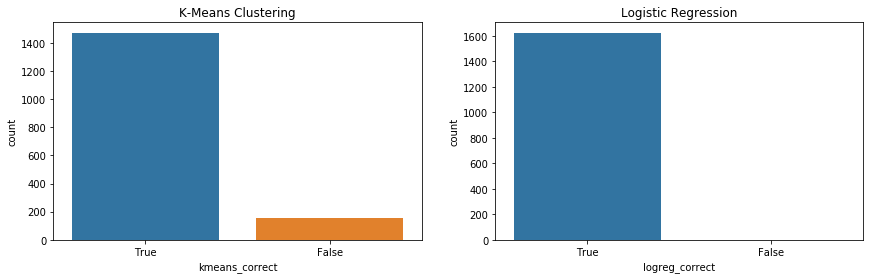

In [34]:
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(right=2)
sns.countplot(x=result_df['kmeans_correct'], order=[True,False], ax=ax[0]).set_title('K-Means Clustering')
sns.countplot(x=result_df['logreg_correct'], order=[True,False], ax=ax[1]).set_title('Logistic Regression')
fig.show()

### Conclusions

Judging from the plots above, I'd say that Logistic Regression is the clear winner!

But K-Means Clustering didn't do too bad either; especially when you consider the fact that it's not built for the task of supervised learning, like Logistic Regression is!